In [ ]:
!sudo apt-get install texlive-xetex texlive-fonts-recommended texlive-plain-generic
!jupyter nbconvert --to pdf /content/Matching_Algorithm.ipynb

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
from itertools import combinations

pd.options.display.max_columns = None

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score

import numpy as np
from datetime import datetime, date

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [ ]:
df1 = pd.read_csv('/content/drive/MyDrive/CS 571 K Night Stand/truncated_test.csv')
df2 = pd.read_csv('/content/drive/MyDrive/CS 571 K Night Stand/truncated_test.csv')

In [ ]:
today = date.today()  # Get today's date

df1['user.birthDate'] = pd.to_datetime(df1['user.birthDate'])  # Convert 'user.birthDate' column to datetime type in df1

df1['age'] = df1['user.birthDate'].apply(lambda x: today.year - x.year - ((today.month, today.day) < (x.month, x.day)))
# Calculate the age for each row in df1
# - Subtract the birth year from the current year
# - Subtract an additional year if the current month and day are less than the birth month and day
#   (i.e., the birthday hasn't occurred yet this year)

df2['user.birthDate'] = pd.to_datetime(df1['user.birthDate'])  # Convert 'user.birthDate' column to datetime type in df2
# Note: It seems like there might be a typo here. It should probably be df2['user.birthDate'] instead of df1['user.birthDate']

df2['age'] = df2['user.birthDate'].apply(lambda x: today.year - x.year - ((today.month, today.day) < (x.month, x.day)))
# Calculate the age for each row in df2 (identical to the calculation for df1)

In [ ]:
result_df = pd.merge(df1.assign(key=1), df2.assign(key=1), on='key').drop('key', axis=1)
# Merge df1 and df2 on a common key (assigned as 1) and drop the key column

unique_rows = set()  # Create an empty set to store unique pairs of '_id_x' and '_id_y'
drop_indices = []  # Create an empty list to store indices of rows to be dropped

for index, row in result_df.iterrows():
    if row['_id_x'] == row['_id_y']:
        drop_indices.append(index)  # Add index to drop if '_id_x' and '_id_y' are the same
        continue

    if not (float(row['user.ageFilterMin_y']) <= float(row['age_x']) <= float(row['user.ageFilterMax_y'])):
        drop_indices.append(index)  # Add index to drop if 'age_x' is not within the range of 'user.ageFilterMin_y' and 'user.ageFilterMax_y'
        continue

    if not (float(row['user.ageFilterMin_x']) <= float(row['age_y']) <= float(row['user.ageFilterMax_x'])):
        drop_indices.append(index)  # Add index to drop if 'age_y' is not within the range of 'user.ageFilterMin_x' and 'user.ageFilterMax_x'
        continue

    if row['user.genderFilter_x'] != 'M and F' and row['user.gender_y'] != row['user.genderFilter_x']:
        drop_indices.append(index)  # Add index to drop if 'user.genderFilter_x' is not 'M and F' and 'user.gender_y' does not match 'user.genderFilter_x'
        continue

    if row['user.genderFilter_y'] != 'M and F' and row['user.gender_x'] != row['user.genderFilter_y']:
        drop_indices.append(index)  # Add index to drop if 'user.genderFilter_y' is not 'M and F' and 'user.gender_x' does not match 'user.genderFilter_y'
        continue

    pair = (row['_id_x'], row['_id_y'])  # Create a tuple of '_id_x' and '_id_y'
    flipped_pair = (row['_id_y'], row['_id_x'])  # Create a flipped tuple of '_id_y' and '_id_x'

    if flipped_pair in unique_rows:
        drop_indices.append(index)  # Add index to drop if the flipped pair already exists in unique_rows
    else:
        unique_rows.add(pair)  # Add the pair to unique_rows if it doesn't exist

df = result_df.drop(drop_indices)  # Drop the rows with indices in drop_indices

# List of columns to be dropped
columns_to_drop = ['Unnamed: 0_x', '__v_x', 'user.ageFilterMax_x', 'user.ageFilterMin_x', 'user.birthDate_x',
                   'user.createDate_x', 'user.education_x', 'user.educationLevel_x', 'user.genderFilter_x',
                   'user.instagram_x', 'user.interestedIn_x', 'user.jobs_x', 'user.schools_x', 'user.spotify_x',
                   'userId_x', 'Unnamed: 0_y', '__v_y', 'user.ageFilterMax_y', 'user.ageFilterMin_y',
                   'user.birthDate_y', 'user.createDate_y', 'user.education_y', 'user.educationLevel_y',
                   'user.genderFilter_y', 'user.instagram_y', 'user.interestedIn_y', 'user.jobs_y',
                   'user.schools_y', 'user.spotify_y', 'userId_y', 'conversations_x', 'conversations_y',
                   'user.country_y', 'user.country_x', 'user.gender_x', 'user.gender_y', 'user.cityName_x',
                   'user.cityName_y']

df = df.drop(columns=columns_to_drop)  # Drop the specified columns from the DataFrame

In [ ]:
df = df.dropna() # Drop rows with any missing values (NaN) from the DataFrame

df

,_id_x,conversationsMeta.averageConversationLength_x,conversationsMeta.averageConversationLengthInDays_x,conversationsMeta.longestConversation_x,conversationsMeta.longestConversationInDays_x,conversationsMeta.medianConversationLength_x,conversationsMeta.medianConversationLengthInDays_x,conversationsMeta.nrOfConversations_x,conversationsMeta.nrOfGhostingsAfterInitialMessage_x,conversationsMeta.nrOfOneMessageConversations_x,conversationsMeta.percentOfOneMessageConversations_x,neg_x,neu_x,pos_x,compound_x,sadness_x,joy_x,love_x,anger_x,fear_x,surprise_x,age_x,_id_y,conversationsMeta.averageConversationLength_y,conversationsMeta.averageConversationLengthInDays_y,conversationsMeta.longestConversation_y,conversationsMeta.longestConversationInDays_y,conversationsMeta.medianConversationLength_y,conversationsMeta.medianConversationLengthInDays_y,conversationsMeta.nrOfConversations_y,conversationsMeta.nrOfGhostingsAfterInitialMessage_y,conversationsMeta.nrOfOneMessageConversations_y,conversationsMeta.percentOfOneMessageConversations_y,neg_y,neu_y,pos_y,compound_y,sadness_y,joy_y,love_y,anger_y,fear_y,surprise_y,age_y
8,00b74e27ad1cbb2ded8e907fcc49eaaf,8.560217,10.236620,133,683.557442,3,0.081134,739,66,226,30.581867,0.037953,0.862745,0.096905,0.115272,0.048039,0.651042,0.028687,0.212246,0.048507,0.011479,48,1e74b4cb4b126a8f34b2d9b1fda0a92f,8.119155,4.407375,123,211.174363,4,0.036007,663,85,123,18.552036,0.032515,0.838247,0.118465,0.106037,0.060642,0.387340,0.018125,0.435464,0.091311,0.007118,31
164,00b74e27ad1cbb2ded8e907fcc49eaaf,8.560217,10.236620,133,683.557442,3,0.081134,739,66,226,30.581867,0.037953,0.862745,0.096905,0.115272,0.048039,0.651042,0.028687,0.212246,0.048507,0.011479,48,1707d68439108206ed62a80d7288d897,9.773810,3.228369,94,116.485104,2,0.015949,84,14,22,26.190476,0.028921,0.948431,0.010470,-0.028939,0.026291,0.342979,0.030048,0.556334,0.038030,0.006318,28
1227,024610702baf540af5637873cd1534e9,4.495690,3.973980,36,622.466528,2,0.000069,464,16,56,12.068966,0.037953,0.862745,0.096905,0.115272,0.048039,0.651042,0.028687,0.212246,0.048507,0.011479,26,41710353e1db856531fde70c26660a19,8.472826,3.387779,183,597.283299,3,0.028542,368,75,51,13.858696,0.047620,0.696125,0.256253,0.293774,0.071213,0.541133,0.049893,0.258732,0.067331,0.011698,24
1247,024610702baf540af5637873cd1534e9,4.495690,3.973980,36,622.466528,2,0.000069,464,16,56,12.068966,0.037953,0.862745,0.096905,0.115272,0.048039,0.651042,0.028687,0.212246,0.048507,0.011479,26,63f8a7720b76ead4114b8c9fdfe2648a,1.285185,0.325060,22,19.278576,0,0.000000,540,325,93,17.222222,0.054013,0.763761,0.179347,0.250185,0.058304,0.547677,0.025643,0.298342,0.053650,0.016384,27
1257,024610702baf540af5637873cd1534e9,4.495690,3.973980,36,622.466528,2,0.000069,464,16,56,12.068966,0.037953,0.862745,0.096905,0.115272,0.048039,0.651042,0.028687,0.212246,0.048507,0.011479,26,879d7037342891ec4380dcfd065f73c0,10.573019,13.638172,1108,1524.729398,3,0.023368,2335,168,636,27.237687,0.057925,0.768518,0.156627,0.091602,0.058153,0.461066,0.024056,0.337668,0.100934,0.018123,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695773,3edd8bbdbaf42f86a299edd10aa46412,4.224978,1.636114,151,345.116250,1,0.000000,1129,443,233,20.637733,0.048440,0.737418,0.207014,0.167686,0.054663,0.489902,0.026817,0.339566,0.077240,0.011811,23,a66ec1d1d58b9d545426e832f7dae8e9,3.518519,1.712238,17,89.741528,2,0.005046,81,4,35,43.209877,0.030681,0.725298,0.244004,0.300991,0.025501,0.658533,0.032179,0.241910,0.032416,0.009460,26
703025,41ad495592a6ffd14b1df8e5eb9b0ee3,1.750000,0.015217,4,0.060868,1,0.000000,4,0,3,75.000000,0.021571,0.851857,0.126571,0.027243,0.013920,0.451598,0.007775,0.457977,0.065384,0.003345,40,30884e406311720cadd106930c2f5c9d,5.269841,0.909057,45,9.797280,3,0.052685,63,4,12,19.047619,0.029036,0.807587,0.160370,0.245122,0.047575,0.586741,0.018737,0.262010,0.069243,0.015694,38
710279,

In [ ]:
cols = ['conversations',
        'conversationsMeta.averageConversationLength',
        'conversationsMeta.averageConversationLengthInDays',
        'conversationsMeta.longestConversation',
        'conversationsMeta.longestConversationInDays',
        'conversationsMeta.medianConversationLength',
        'conversationsMeta.medianConversationLengthInDays',
        'conversationsMeta.nrOfConversations',
        'conversationsMeta.nrOfGhostingsAfterInitialMessage',
        'conversationsMeta.nrOfOneMessageConversations',
        'conversationsMeta.percentOfOneMessageConversations',
        'neg',
        'neu',
        'pos',
        'compound',
        'sadness',
        'joy',
        'love',
        'anger',
        'fear',
        'surprise',
        'age']
# Define a list 'cols' containing column names

mydict = {} # Create an empty dictionary 'mydict'

for i in range(len(cols)):
    xv = cols[i] + "_x"
    yv = cols[i] + "_y"
    mydict[xv] = yv
    # Iterate over the indices of 'cols'
    # For each column name in 'cols':
    #   - Create a new column name 'xv' by appending "_x" to the original column name
    #   - Create a new column name 'yv' by appending "_y" to the original column name
    #   - Add a key-value pair to 'mydict' where 'xv' is the key and 'yv' is the value

print(mydict) # Print the resulting dictionary 'mydict'

{'conversations_x': 'conversations_y', 'conversationsMeta.averageConversationLength_x': 'conversationsMeta.averageConversationLength_y', 'conversationsMeta.averageConversationLengthInDays_x': 'conversationsMeta.averageConversationLengthInDays_y', 'conversationsMeta.longestConversation_x': 'conversationsMeta.longestConversation_y', 'conversationsMeta.longestConversationInDays_x': 'conversationsMeta.longestConversationInDays_y', 'conversationsMeta.medianConversationLength_x': 'conversationsMeta.medianConversationLength_y', 'conversationsMeta.medianConversationLengthInDays_x': 'conversationsMeta.medianConversationLengthInDays_y', 'conversationsMeta.nrOfConversations_x': 'conversationsMeta.nrOfConversations_y', 'conversationsMeta.nrOfGhostingsAfterInitialMessage_x': 'conversationsMeta.nrOfGhostingsAfterInitialMessage_y', 'conversationsMeta.nrOfOneMessageConversations_x': 'conversationsMeta.nrOfOneMessageConversations_y', 'conversationsMeta.percentOfOneMessageConversations_x': 'conversation

In [ ]:
for x in mydict:
    newcol = x[:len(x)-2] + "_combined"
    # Iterate over the keys in 'mydict'
    # For each key 'x':
    #   - Create a new column name 'newcol' by removing the last two characters from 'x' (which are "_x")
    #     and appending "_combined" to the resulting string

    if x in df:
        df[newcol] = abs(df[x] - df[mydict[x]])
        # Check if the key 'x' exists as a column in the DataFrame 'df'
        # If 'x' exists in 'df':
        #   - Create a new column in 'df' with the name 'newcol'
        #   - Calculate the absolute difference between the values in column 'x' and the corresponding values
        #     in the column specified by 'mydict[x]' (which is the "_y" version of the column)
        #   - Assign the absolute difference to the new column 'newcol' in 'df'

In [ ]:
cols_drop = ['conversationsMeta.averageConversationLength_x',
       'conversationsMeta.averageConversationLengthInDays_x',
       'conversationsMeta.longestConversation_x',
       'conversationsMeta.longestConversationInDays_x',
       'conversationsMeta.medianConversationLength_x',
       'conversationsMeta.medianConversationLengthInDays_x',
       'conversationsMeta.nrOfConversations_x',
       'conversationsMeta.nrOfGhostingsAfterInitialMessage_x',
       'conversationsMeta.nrOfOneMessageConversations_x',
       'conversationsMeta.percentOfOneMessageConversations_x', 'neg_x',
       'neu_x', 'pos_x', 'compound_x', 'sadness_x', 'joy_x', 'love_x',
       'anger_x', 'fear_x', 'surprise_x', 'age_x',
       'conversationsMeta.averageConversationLength_y',
       'conversationsMeta.averageConversationLengthInDays_y',
       'conversationsMeta.longestConversation_y',
       'conversationsMeta.longestConversationInDays_y',
       'conversationsMeta.medianConversationLength_y',
       'conversationsMeta.medianConversationLengthInDays_y',
       'conversationsMeta.nrOfConversations_y',
       'conversationsMeta.nrOfGhostingsAfterInitialMessage_y',
       'conversationsMeta.nrOfOneMessageConversations_y',
       'conversationsMeta.percentOfOneMessageConversations_y', 'neg_y',
       'neu_y', 'pos_y', 'compound_y', 'sadness_y', 'joy_y', 'love_y',
       'anger_y', 'fear_y', 'surprise_y', 'age_y']

df = df.drop(columns=cols_drop)
df

,_id_x,_id_y,conversationsMeta.averageConversationLength_combined,conversationsMeta.averageConversationLengthInDays_combined,conversationsMeta.longestConversation_combined,conversationsMeta.longestConversationInDays_combined,conversationsMeta.medianConversationLength_combined,conversationsMeta.medianConversationLengthInDays_combined,conversationsMeta.nrOfConversations_combined,conversationsMeta.nrOfGhostingsAfterInitialMessage_combined,conversationsMeta.nrOfOneMessageConversations_combined,conversationsMeta.percentOfOneMessageConversations_combined,neg_combined,neu_combined,pos_combined,compound_combined,sadness_combined,joy_combined,love_combined,anger_combined,fear_combined,surprise_combined,age_combined
8,00b74e27ad1cbb2ded8e907fcc49eaaf,1e74b4cb4b126a8f34b2d9b1fda0a92f,0.441061,5.829245,10,472.383079,1,0.045127,76,19,103,12.029831,0.005438,0.024499,0.021560,0.009235,0.012603,0.263702,0.010561,0.223218,0.042804,0.004362,17
164,00b74e27ad1cbb2ded8e907fcc49eaaf,1707d68439108206ed62a80d7288d897,1.213593,7.008251,39,567.072338,1,0.065185,655,52,204,4.391391,0.009033,0.085686,0.086434,0.144210,0.021748,0.308063,0.001361,0.344088,0.010477,0.005162,20
1227,024610702baf540af5637873cd1534e9,41710353e1db856531fde70c26660a19,3.977136,0.586201,147,25.183229,1,0.028472,96,59,5,1.789730,0.009666,0.166621,0.159348,0.178503,0.023174,0.109910,0.021206,0.046486,0.018824,0.000219,2
1247,024610702baf540af5637873cd1534e9,63f8a7720b76ead4114b8c9fdfe2648a,3.210504,3.648920,14,603.187951,2,0.000069,76,309,37,5.153257,0.016059,0.098985,0.082443,0.134914,0.010265,0.103365,0.003044,0.086096,0.005143,0.004905,1
1257,024610702baf540af5637873cd1534e9,879d7037342891ec4380dcfd065f73c0,6.077330,9.664192,1072,902.262870,1,0.023299,1871,152,580,15.168722,0.019972,0.094228,0.059722,0.023669,0.010114,0.189977,0.004631,0.125422,0.052427,0.006644,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695773,3edd8bbdbaf42f86a299edd10aa46412,a66ec1d1d58b9d545426e832f7dae8e9,0.706459,0.076124,134,255.374722,1,0.005046,1048,439,198,22.572144,0.017759,0.012119,0.036989,0.133305,0.029162,0.168631,0.005362,0.097656,0.044824,0.002351,3
703025,41ad495592a6ffd14b1df8e5eb9b0ee3,30884e406311720cadd106930c2f5c9d,3.519841,0.893840,41,9.736412,2,0.052685,59,4,9,55.952381,0.007465,0.044270,0.033799,0.217879,0.033655,0.135143,0.010962,0.195968,0.003859,0.012348,2
710279,a058e4c7a0102bceaf4e893863b8e3c0,30884e406311720cadd106930c2f5c9d,3.388582,9.508641,12,1065.267523,2,0.052685,636,176,265,20.580421,0.018478,0.003084,0.015359,0.031846,0.034929,0.235254,0.012625,0.141765,0.034985,0.010950,3
711489,19b418ce85ee67f92141aa08ac81fe09,4edcebaf0e24706604dc37e5b1852981,15.301815,6.341358,83,1603.832813,3,1.937477,389,61,74,0.940594,0.002079,0.073502,0.061760,0.052763,0.001390,0.087952,0.000464,0.024757,0.063312,0.001044,3


In [ ]:
exclude_cols = ['_id_x', '_id_y']
# List of columns to exclude from the sum calculation

exclude = ['_id_x', '_id_y', 'match_result']
# List of columns to exclude from the feature matrix X

sum_other_columns = df.drop(columns=exclude_cols).sum(axis=1)
# Calculate the sum of all columns in df, excluding the columns in exclude_cols
# The sum is calculated along axis=1 (row-wise)

df['match_result'] = np.where(
    sum_other_columns < 300,
    np.random.choice([1, 0], size=len(df), p=[0.95, 0.05]),
    np.random.choice([1, 0], size=len(df), p=[0.05, 0.95])
)
# Create a new column 'match_result' in df based on the sum of other columns
# If the sum is less than 300:
#   - Randomly assign 1 with a probability of 0.95 and 0 with a probability of 0.05
# If the sum is greater than or equal to 300:
#   - Randomly assign 1 with a probability of 0.05 and 0 with a probability of 0.95
# The size of the random assignment is equal to the length of df

X = df[[col for col in df.columns if col not in exclude]]
# Create the feature matrix X by selecting all columns from df that are not in the exclude list

y = df[['match_result']]
# Create the target variable y by selecting the 'match_result' column from df

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Split the data into training and testing sets
# X_train: feature matrix for training
# X_test: feature matrix for testing
# y_train: target variable for training
# y_test: target variable for testing
# test_size=0.2 indicates that 20% of the data will be used for testing
# random_state=42 ensures reproducibility of the random split

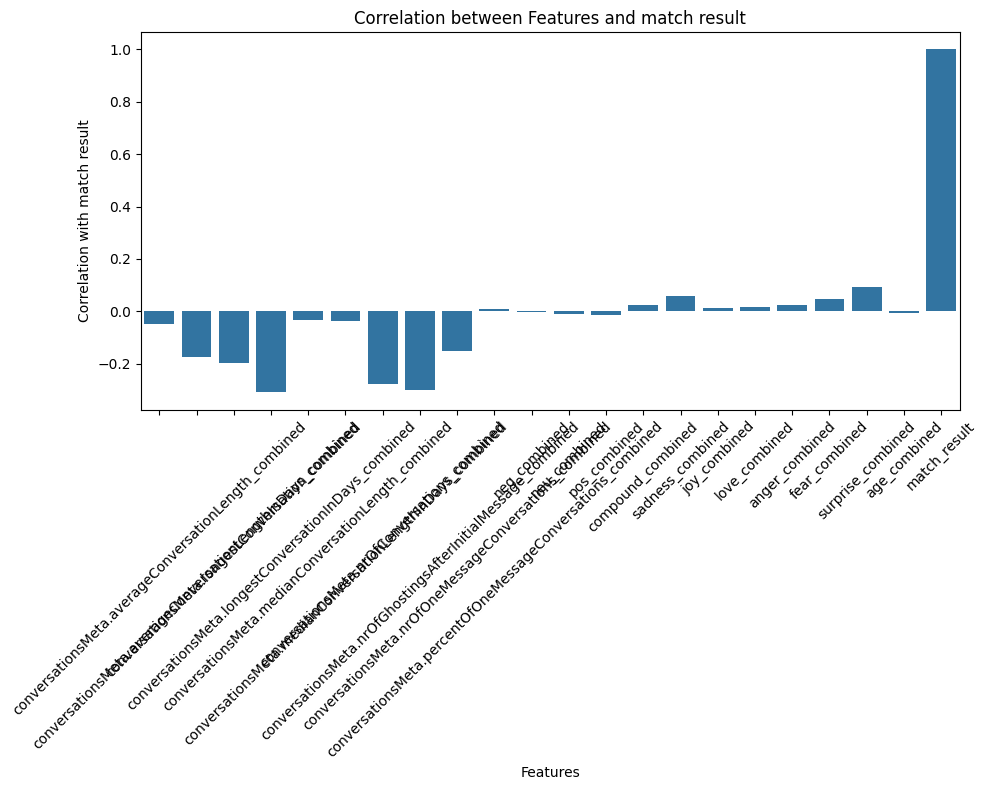

In [ ]:
columns_to_exclude = ['_id_x', '_id_y']
# List of columns to exclude from the correlation calculation

columns_for_correlation = [col for col in df.columns if col not in columns_to_exclude]
# List of columns to include in the correlation calculation
# It includes all columns from df except those in columns_to_exclude

correlation_matrix = df[columns_for_correlation].corr()
# Calculate the correlation matrix for the selected columns
# corr() calculates the pairwise correlation between columns

correlation_with_y = correlation_matrix['match_result']
# Extract the correlation values between each feature and the 'match_result' column

plt.figure(figsize=(10, 8))
# Create a new figure with a specified size

sns.barplot(x=correlation_with_y.index, y=correlation_with_y.values)
# Create a bar plot using seaborn
# x-axis: feature names (index of correlation_with_y)
# y-axis: correlation values (values of correlation_with_y)

plt.xlabel('Features')
# Set the label for the x-axis

plt.ylabel('Correlation with match result')
# Set the label for the y-axis

plt.title('Correlation between Features and match result')
# Set the title of the plot

plt.xticks(rotation=45)
# Rotate the x-axis tick labels by 45 degrees for better readability

plt.tight_layout()
# Adjust the spacing between subplots to prevent overlapping

plt.show()
# Display the plot

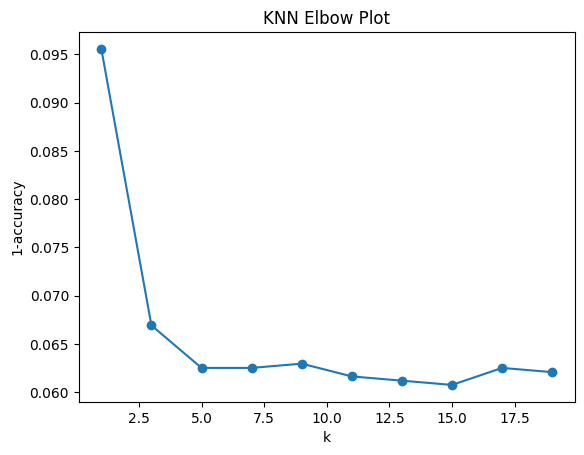

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Define a list of different values for the number of neighbors
neigh_vals = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19]

# Create an empty list to store the error rates
arr = []

# Iterate over different values of neighbors
for x in neigh_vals:
    # Create a KNN classifier with the current number of neighbors
    neigh = KNeighborsClassifier(n_neighbors=x)

    # Fit the classifier to the training data
    neigh.fit(X_train, y_train)

    # Make predictions on the test data
    ypred = neigh.predict(X_test)

    # Calculate the accuracy score
    accuracy = accuracy_score(y_test, ypred)

    # Append the error rate (1 - accuracy) to the list
    arr.append(1 - accuracy)

# Plot the error rate against the number of neighbors
plt.plot(neigh_vals, arr, marker='o', linestyle='-')
plt.title("KNN Elbow Plot")
plt.xlabel('k')
plt.ylabel('1-accuracy')
# Display the plot
plt.show()

Let's first try predicting matches using Logistic Regression

In [ ]:
param_grid = {
    'C': [0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'],
    'class_weight': ['balanced']
}
# Define the parameter grid for grid search
# It includes different values for the hyperparameters:
# - C: regularization strength (0.1, 1, 10)
# - penalty: regularization norm (L1, L2)
# - solver: optimization algorithm (liblinear, saga)
# - class_weight: class weighting strategy (balanced)

model = LogisticRegression()
# Create an instance of the Logistic Regression model

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='precision')
# Create a GridSearchCV object
# - estimator: the model to be optimized (Logistic Regression)
# - param_grid: the parameter grid for grid search
# - cv: number of cross-validation splits (5-fold cross-validation)
# - scoring: the evaluation metric (precision)

grid_search.fit(X_train, y_train)
# Fit the GridSearchCV object to the training data (X_train, y_train)
# It will search for the best combination of hyperparameters based on the parameter grid

best_model = grid_search.best_estimator_
# Get the best model found by grid search

y_pred = best_model.predict(X_test)
# Make predictions on the test data (X_test) using the best model

precision = precision_score(y_test, y_pred)
# Calculate the precision score using the true labels (y_test) and the predicted labels (y_pred)

print("Best parameters:", grid_search.best_params_)
# Print the best hyperparameters found by grid search

print("Precision:", precision)
# Print the precision score

Best parameters: {'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'saga'}
Precision: 0.5887850467289719


That isn't that great. Let's try again but with Random Forests.

In [ ]:
params = {
    "min_impurity_decrease": [0, 0.1],
    "n_estimators": [100, 200, 300],
    "criterion": ["log_loss"],
    "max_depth": [8, 9, 10, 11],
    "ccp_alpha": [0, 0.1, 0.2],
    "class_weight": ["balanced"]
}
# Define the parameter grid for grid search
# It includes different values for the hyperparameters:
# - min_impurity_decrease: minimum impurity decrease for splitting a node (0, 0.1)
# - n_estimators: number of trees in the forest (100, 200, 300)
# - criterion: function to measure the quality of a split (log_loss)
# - max_depth: maximum depth of the tree (8, 9, 10, 11)
# - ccp_alpha: complexity parameter for pruning (0, 0.1, 0.2)
# - class_weight: class weighting strategy (balanced)

model = RandomForestClassifier()
# Create an instance of the Random Forest Classifier model

clf = GridSearchCV(model, params, cv=5, scoring='precision')
# Create a GridSearchCV object
# - model: the model to be optimized (Random Forest Classifier)
# - params: the parameter grid for grid search
# - cv: number of cross-validation splits (5-fold cross-validation)
# - scoring: the evaluation metric (precision)

clf.fit(X_train, y_train)
# Fit the GridSearchCV object to the training data (X_train, y_train)
# It will search for the best combination of hyperparameters based on the parameter grid

y_pred_test_cv = clf.predict(X_test)
# Make predictions on the test data (X_test) using the best model found by grid search

precision = precision_score(y_test, y_pred_test_cv)
# Calculate the precision score using the true labels (y_test) and the predicted labels (y_pred_test_cv)

print("CV Precision:", precision)
# Print the precision score obtained from the best model found by grid search

print(clf.best_params_)
# Print the best hyperparameters found by grid search

print(clf.best_score_)
# Print the best score (precision) obtained during grid search

CV Precision: 0.9175475687103594
{'ccp_alpha': 0, 'class_weight': 'balanced', 'criterion': 'log_loss', 'max_depth': 11, 'min_impurity_decrease': 0, 'n_estimators': 300}
0.89868204088147
